# Import required libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# prepare_dataset

In [2]:
# Define the path to the training dataset
data_train = r"D:\AMIT Course\Final Project\Face Mask Detection ~12K Images Dataset\F\Face Mask Dataset\Train"

# Create empty lists to hold image paths and their corresponding labels
filepaths = []
labels = []

# Loop over each label/class directory inside the training path
for label_name in os.listdir(data_train):
    class_folder = os.path.join(data_train, label_name)
    
    # Loop over each image file in the class directory
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)
        
        # Append the image path and label to the respective lists
        filepaths.append(image_path)
        labels.append(label_name)

# Combine the file paths and labels into a Pandas DataFrame
train_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Output the DataFrame to verify the data structure
train_df

filepaths       labels
0      D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
1      D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
2      D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
3      D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
4      D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
...                                                  ...          ...
9998   D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
9999   D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
10000  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
10001  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
10002  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask

[10003 rows x 2 columns]

In [3]:
# Define the path to the validation dataset
data_valid = r"D:\AMIT Course\Final Project\Face Mask Detection ~12K Images Dataset\F\Face Mask Dataset\Validation"

# Create empty lists to hold image paths and their corresponding labels
filepaths = []
labels = []

# Loop over each label/class directory inside the validation path
for label_name in os.listdir(data_valid):
    class_folder = os.path.join(data_valid, label_name)
    
    # Loop over each image file in the class directory
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)
        
        # Append the image path and label to the respective lists
        filepaths.append(image_path)
        labels.append(label_name)

# Combine the file paths and labels into a Pandas DataFrame
valid_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Output the DataFrame to verify the data structure
valid_df

filepaths       labels
0    D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
1    D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
2    D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
3    D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
4    D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
..                                                 ...          ...
795  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
796  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
797  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
798  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
799  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask

[800 rows x 2 columns]

In [4]:
# Define the path to the test dataset (collected from friends)
data_test_friends = r"D:\AMIT Course\Final Project\Face Mask Detection ~12K Images Dataset\F\Face Mask Dataset\Test"

# Create empty lists to hold image paths and their corresponding labels
filepaths = []
labels = []

# Loop over each label/class directory inside the test path
for label_name in os.listdir(data_test_friends):
    class_folder = os.path.join(data_test_friends, label_name)
    
    # Loop over each image file in the class directory
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)
        
        # Append the image path and label to the respective lists
        filepaths.append(image_path)
        labels.append(label_name)

# Combine the file paths and labels into a Pandas DataFrame
test_friends_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Output the DataFrame to verify the data structure
test_friends_df

filepaths       labels
0   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
1   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
2   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
3   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
4   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
5   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
6   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
7   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
8   D:\AMIT Course\Final Project\Face Mask Detecti...     WithMask
9   D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
10  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
11  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
12  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
13  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
14  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
15  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
16  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask
17  D:\AMIT Course\Final Project\Face Mask Detecti...  WithoutMask

# data_generators

In [5]:
# Define the data augmentation strategy for training and validation sets
datagen = ImageDataGenerator(
    rescale=1.0 / 255,           # Normalize pixel values to [0, 1]
    rotation_range=0.45,         # Random rotation in degrees
    width_shift_range=0.1,       # Random horizontal shift
    height_shift_range=0.1,      # Random vertical shift
    shear_range=0.2,             # Shear intensity
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    vertical_flip=True           # Random vertical flip
)

# Apply augmentation to training dataset
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',           # Column with image paths
    y_col='labels',              # Column with class labels
    target_size=(224, 224),      # Resize images to 224x224
    batch_size=32,
    color_mode='rgb',            # Use RGB color space
    class_mode='categorical'     # For multi-class classification
)

# Apply same augmentation to validation dataset
validation_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

# Define a separate generator for test data (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load test images using the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_friends_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

Found 10003 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 18 validated image filenames belonging to 2 classes.


# base_model_setup

In [6]:
# Load the base model with ImageNet weights, excluding the top classification layer
base_model = InceptionResNetV2(
    include_top=False,              # Exclude the fully-connected layers at the top
    weights="imagenet",             # Load pretrained weights from ImageNet
    input_shape=(224, 224, 3),      # Input image shape
    pooling="max",                  # Apply global max pooling after the convolutional base
    name="inception_resnet_v2"      # Name of the model
)

# Freeze the base model so its weights will not be updated during training
base_model.trainable = False

# build_classifier_model

In [7]:
# Define the final model architecture on top of the pre-trained base model
model = Sequential([
    base_model,                      # Frozen base model for feature extraction
    Flatten(),                       # Flatten output of the base model
    Dense(512, activation='relu'),   # Dense hidden layers for learning patterns
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')   # Output layer for 2-class classification
])

# Compile the model with Adamax optimizer and categorical crossentropy loss
model.compile(
    optimizer=Adamax(learning_rate=0.0001),  # Optimizer with learning rate
    loss='categorical_crossentropy',         # Suitable for one-hot encoded labels
    metrics=['accuracy']                     # Track accuracy during training
)

# Print the model summary to check architecture and parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,298,306 (210.95 MB)

 Trainable params: 961,570 (3.67 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

# Early stopping after 3 epochs without improvement in validation loss

In [8]:
# Set up EarlyStopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',             # Stop training when validation loss stops improving
    patience=3,                     # Wait for 3 epochs before stopping
    restore_best_weights=True       # Roll back to the best weights observed during training
)

# Save only the best performing model based on validation accuracy

In [9]:
# Configure the callback to save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',     # Save model in Keras format
    monitor='val_accuracy',          # Monitor validation accuracy
    save_best_only=True,             # Save only when the model improves
    mode='max',                      # Higher accuracy is better
    save_weights_only=False,         # Save full model (not just weights)
    verbose=1                        # Output message when model is saved
)

# Reduce learning rate if validation loss plateaus for 3 epochs

In [10]:
# Reduce learning rate when the validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.1,             # Reduce LR by 10x when triggered
    patience=3,             # Number of epochs with no improvement before reduction
    verbose=1               # Log the LR change
)

# Train the model with callbacks for early stopping, checkpointing, and learning rate scheduling

In [11]:
# Train the model with training and validation data generators
# Includes early stopping, learning rate reduction, and best model checkpointing
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=11,  # Set to a higher value (e.g. 20–30) for actual training
    callbacks=[
        early_stopping,
        model_checkpoint,
        reduce_lr
    ],
    verbose=1
)

D:\AMIT Course\Machine Learning and AI Diploma\IDE Anaconda\New folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/11
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.9071 - loss: 0.2468
Epoch 1: val_accuracy improved from -inf to 0.97500, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9073 - loss: 0.2464 - val_accuracy: 0.9750 - val_loss: 0.0914 - learning_rate: 1.0000e-04
Epoch 2/11
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.9796 - loss: 0.0667
Epoch 2: val_accuracy improved from 0.97500 to 0.98125, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9796 - loss: 0.0667 - val_accuracy: 0.9812 - val_loss: 0.0577 - learning_rate: 1.0000e-04
Epoch 3/11
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9804 - loss: 0.0588
Epoch 3: val_accuracy did not improve from 0.98125
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.9804 - loss: 0.0588 - val_accuracy: 0.9800 - val_loss: 0.0703 - learning_rate: 1.0000e-04
Epoch 4/11
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.9851

# plot_training_curves

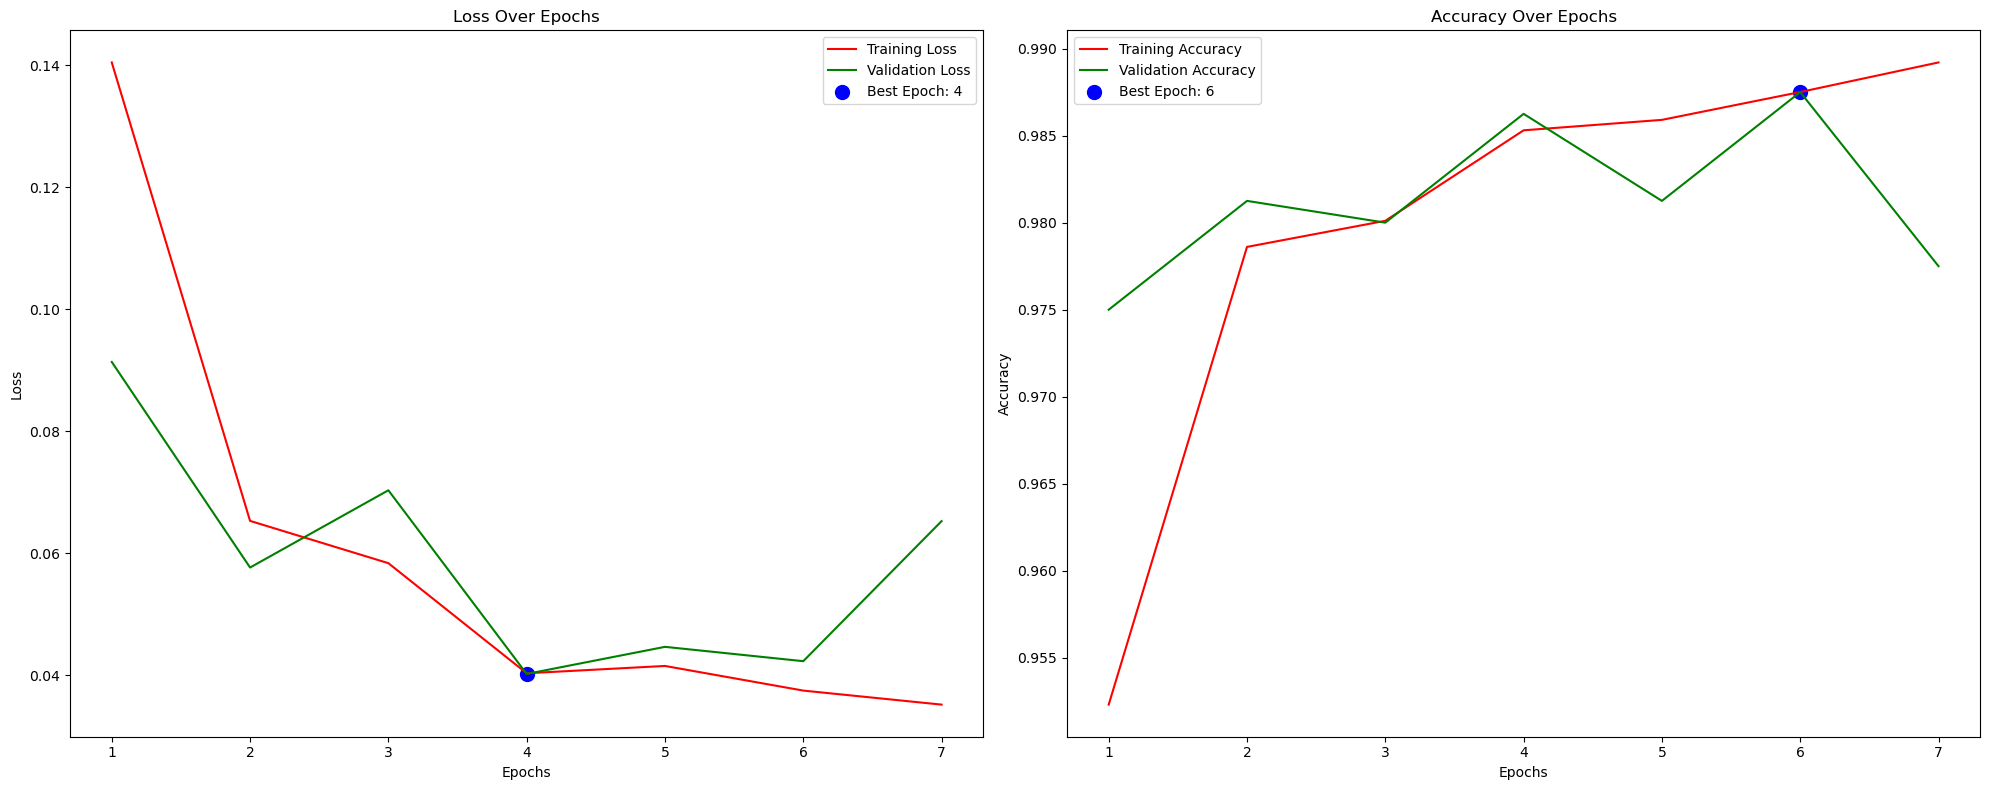

In [12]:
# Extract metrics from training history
tr_acc = history.history['accuracy']         # Training accuracy
val_acc = history.history['val_accuracy']    # Validation accuracy
tr_loss = history.history['loss']            # Training loss
val_loss = history.history['val_loss']       # Validation loss
epochs = [i + 1 for i in range(len(tr_acc))] # Epoch range for plotting

# Create subplots: loss and accuracy
plt.figure(figsize=(20, 8))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(np.argmin(val_loss) + 1, min(val_loss), s=100, c='blue',
            label=f'Best Epoch: {np.argmin(val_loss) + 1}')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(np.argmax(val_acc) + 1, max(val_acc), s=100, c='blue',
            label=f'Best Epoch: {np.argmax(val_acc) + 1}')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# evaluate_model

In [13]:
# Evaluate the model on the training dataset
train_score = model.evaluate(train_generator)

# Evaluate the model on the validation dataset
valid_score = model.evaluate(validation_generator)

# Evaluate the model on the external test dataset (friends' dataset)
test_score_friends = model.evaluate(test_generator)

# Print the evaluation results with formatting
print("=== Training Performance ===")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 30)

print("=== Validation Performance ===")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 30)

print("=== Test Performance (Friends Dataset) ===")
print(f"Test Loss: {test_score_friends[0]:.4f}")
print(f"Test Accuracy: {test_score_friends[1]*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 289s 924ms/step - accuracy: 0.9858 - loss: 0.0427
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 925ms/step - accuracy: 0.9862 - loss: 0.0424
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step - accuracy: 0.8333 - loss: 0.3297
=== Training Performance ===
Train Loss: 0.0391
Train Accuracy: 98.66%
------------------------------
=== Validation Performance ===
Validation Loss: 0.0498
Validation Accuracy: 98.12%
------------------------------
=== Test Performance (Friends Dataset) ===
Test Loss: 0.3297
Test Accuracy: 83.33%


# Confusion Matrix & Classification Report

=== Classification Report ===
              precision    recall  f1-score   support

    WithMask       0.50      0.67      0.57         9
 WithoutMask       0.50      0.33      0.40         9

    accuracy                           0.50        18
   macro avg       0.50      0.50      0.49        18
weighted avg       0.50      0.50      0.49        18



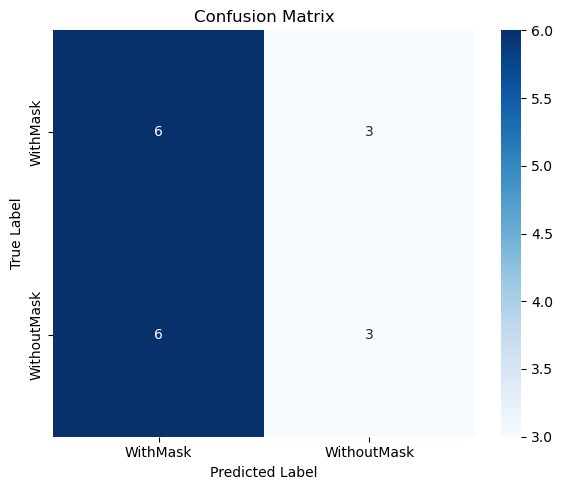

In [14]:
# Get true labels and predictions from the test generator
Y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predict probabilities
Y_pred_probs = model.predict(test_generator, verbose=0)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Generate classification report
print("=== Classification Report ===")
print(classification_report(Y_true, Y_pred, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# plot_test_predictions_by_confidence

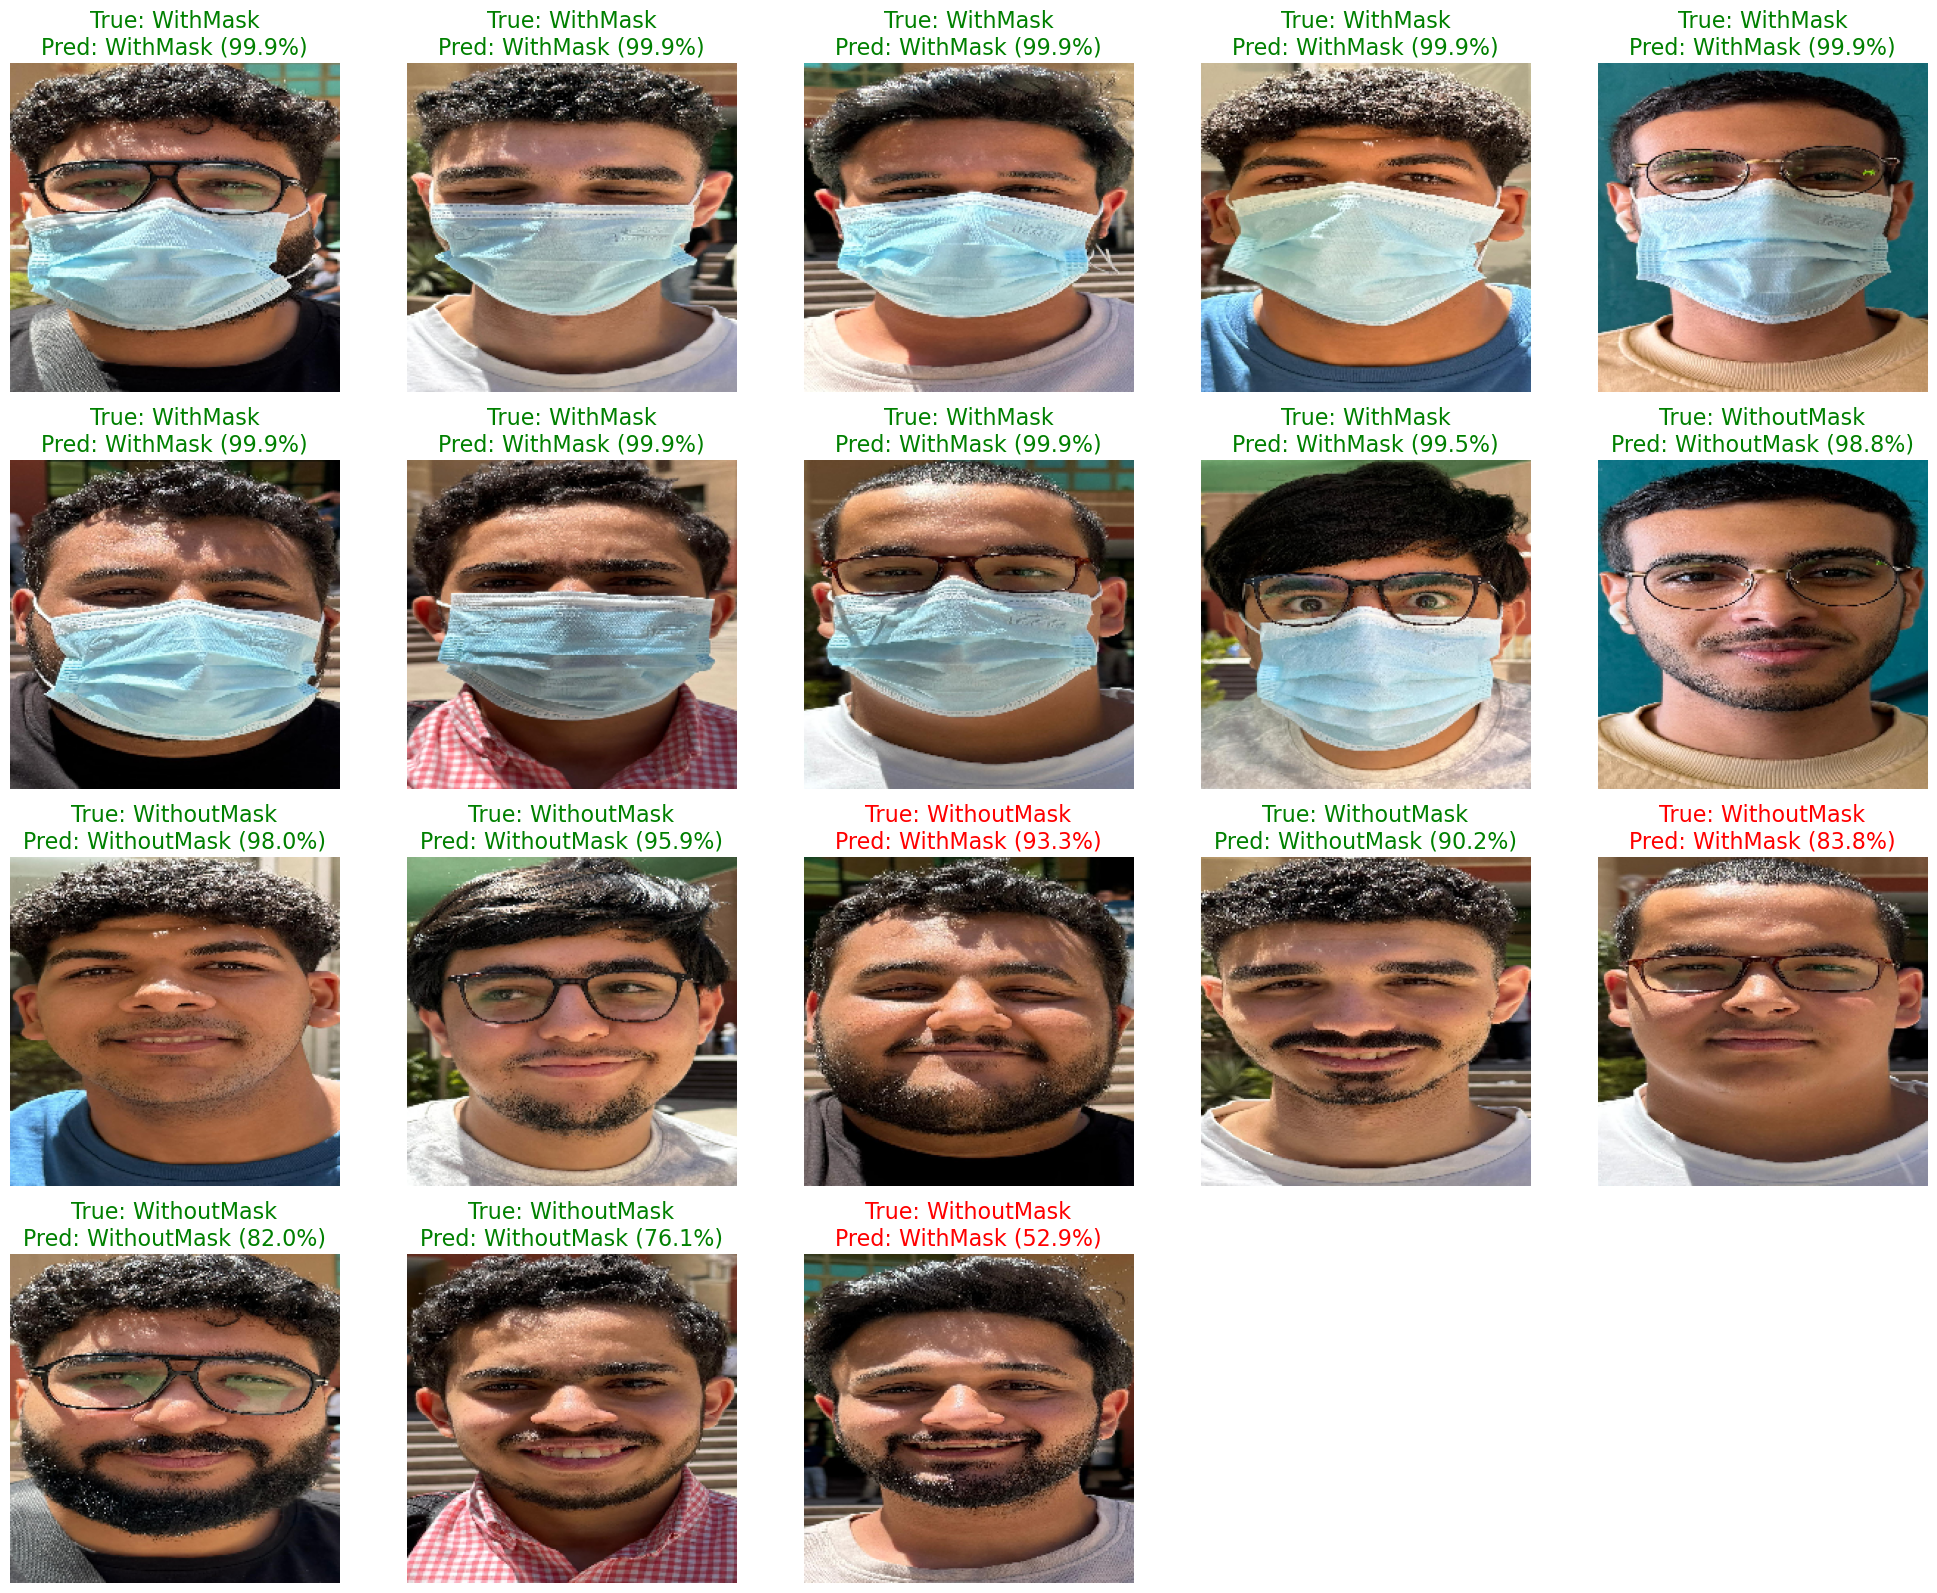

In [15]:
# Get a batch of test images and labels
images, labels = test_generator[0]

# Predict classes for the full test set
predictions = model.predict(test_generator, verbose=0)

# Handle binary or multi-class model output
if predictions.shape[1] == 1:
    # Binary classification (sigmoid)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    confidences = predictions.flatten()
else:
    # Multi-class classification (softmax)
    predicted_classes = np.argmax(predictions, axis=1)
    confidences = np.max(predictions, axis=1)

# Get true class labels from one-hot or integer labels
if labels.ndim == 2 and labels.shape[1] > 1:
    true_classes = np.argmax(labels, axis=1)
else:
    true_classes = labels.astype(int)

# Get the class names (e.g., ['Without Mask', 'With Mask'])
class_labels = list(test_generator.class_indices.keys())

# Clamp confidence values between 0.001 and 0.999 for display purposes
confidences = np.clip(confidences, 0.001, 0.999)

# Sort predictions by confidence (highest first)
sorted_indices = np.argsort(-confidences)
sorted_images = images[sorted_indices]
sorted_true_classes = true_classes[sorted_indices]
sorted_predicted_classes = predicted_classes[sorted_indices]
sorted_confidences = confidences[sorted_indices]

# Function to display images with true and predicted labels
def plot_images(images, true_labels, predicted_labels, class_labels, confidences):
    """
    Display up to 18 test images with true and predicted labels,
    and the model's confidence percentage.
    """
    plt.figure(figsize=(20, 20))
    for i in range(min(18, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow((images[i] * 255).astype(np.uint8))  # Rescale from [0,1] to [0,255]
        plt.axis('off')

        true_name = class_labels[true_labels[i]]
        pred_name = class_labels[predicted_labels[i]]
        color = 'green' if true_name == pred_name else 'red'
        confidence = confidences[i]

        # Show prediction info and confidence on the image
        plt.title(f"True: {true_name}\nPred: {pred_name} ({confidence*100:.1f}%)",
                  color=color, fontsize=16)

    plt.tight_layout()
    plt.show(block=True)

# Plot the sorted test predictions
plot_images(
    sorted_images,
    sorted_true_classes,
    sorted_predicted_classes,
    class_labels,
    sorted_confidences
)

# realtime_mask_detection

In [16]:
print(test_generator.class_indices)

{'WithMask': 0, 'WithoutMask': 1}


In [17]:
# Load the trained face mask detection model
model = load_model('best_model.keras')

# Automatically extract class names from the test generator
class_names = list(test_generator.class_indices.keys())

# Load OpenCV’s DNN-based face detector (Caffe model)
face_net = cv2.dnn.readNetFromCaffe(
    prototxt=r"D:\AMIT Course\Final Project\deploy.prototxt.txt",
    caffeModel=r"D:\AMIT Course\Final Project\res10_300x300_ssd_iter_140000.caffemodel"
)


def predict_mask(face_img):
    """
    Predict whether the given face image is wearing a mask or not.

    Args:
        face_img (np.ndarray): Cropped face image in BGR format.

    Returns:
        label_text (str): Prediction result with confidence.
        color (tuple): BGR color for drawing bounding box.
    """
    # Convert image from BGR to RGB and resize to 224x224
    face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(face_rgb, (224, 224)) / 255.0
    reshaped = np.reshape(resized, (1, 224, 224, 3))

    # Make prediction
    prediction = model.predict(reshaped, verbose=0)[0][0]

    # Determine label index based on threshold
    if prediction <= 0.5:
        label_idx = 1
        confidence = 1 - prediction
    else:
        label_idx = 0
        confidence = prediction

    # Clamp confidence value between 0.0001 and 0.99
    confidence = np.clip(confidence, 0.0001, 0.99)

    # Build label string
    label_name = class_names[label_idx]
    label_text = f"{label_name}: {confidence * 100:.2f}%"

    # Choose color based on label (green for mask, red for no mask)
    if "without" in label_name.lower():
        color = (0, 0, 255)  # Red
    elif "with" in label_name.lower():
        color = (0, 255, 0)  # Green
    else:
        color = (255, 255, 255)  # White fallback

    return label_text, color


def start_camera():
    """
    Start the webcam and perform real-time face mask detection.
    Draw bounding boxes and prediction labels on detected faces.
    """
    cap = cv2.VideoCapture(0)

    # Check if the camera opened successfully
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to read frame.")
            break

        h, w = frame.shape[:2]

        # Convert frame to blob for face detection
        blob = cv2.dnn.blobFromImage(
            frame, 1.0, (300, 300), [104, 117, 123],
            swapRB=False, crop=False
        )
        face_net.setInput(blob)
        detections = face_net.forward()

        # Loop over detected faces
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            if confidence > 0.6:
                # Get face bounding box
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                x1, y1, x2, y2 = box.astype("int")

                # Crop face from frame
                face_img = frame[y1:y2, x1:x2]

                # Skip empty crops
                if face_img.size == 0:
                    continue

                # Predict mask status and get color/label
                label_text, color = predict_mask(face_img)

                # Draw bounding box and label
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label_text, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        # Show the output frame
        cv2.namedWindow("Face Mask Detection - Live", cv2.WINDOW_NORMAL)
        
        cv2.imshow("Face Mask Detection - Live", frame)

        # Press Enter key (13) to exit
        if cv2.waitKey(1) & 0xFF == 13:
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()


# Run detection if this script is executed directly
if __name__ == "__main__":
    start_camera()

# display_detection_examples

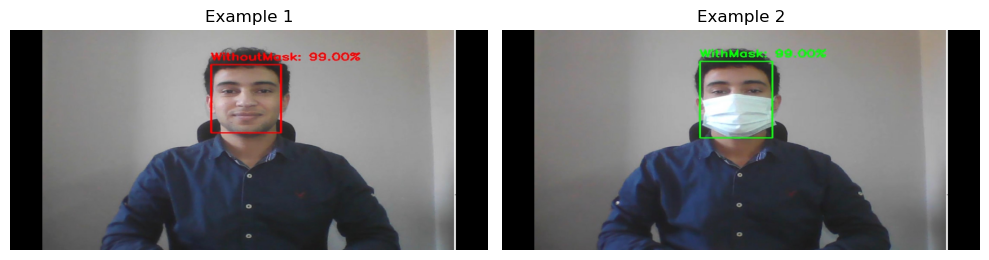

In [18]:
# === Load and Display Two Example Images ===

# Define the file paths of the two images
image_path_1 = r"D:\AMIT Course\Final Project\Detection Ex\1.jpg"  # First image path
image_path_2 = r"D:\AMIT Course\Final Project\Detection Ex\2.jpg"  # Second image path

# Load images using OpenCV
image1 = cv2.imread(image_path_1)
image2 = cv2.imread(image_path_2)

# Check if the images were loaded correctly
if image1 is None:
    raise FileNotFoundError(f"Image not found at: {image_path_1}")
if image2 is None:
    raise FileNotFoundError(f"Image not found at: {image_path_2}")

# Convert BGR to RGB for correct display in matplotlib
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Create a side-by-side figure
plt.figure(figsize=(10, 5))

# Display first image
plt.subplot(1, 2, 1)
plt.imshow(image1_rgb)
plt.title("Example 1")
plt.axis('off')

# Display second image
plt.subplot(1, 2, 2)
plt.imshow(image2_rgb)
plt.title("Example 2")
plt.axis('off')

# Adjust layout and show
plt.tight_layout()
plt.show()

# Project Description

# Face Mask Detection with Deep Learning and Real-Time Video Inference
## This project presents a robust deep learning pipeline for real-time face mask detection, combining computer vision techniques with transfer learning. The system is capable of detecting faces from live webcam feeds and classifying them as either "With Mask" or "Without Mask", with confidence scores displayed on-screen.

## The model is trained on a well-balanced and augmented dataset containing over 12,000 labeled images. It uses InceptionResNetV2 as a powerful feature extractor, followed by custom dense layers for final classification. Comprehensive data augmentation strategies were applied to enhance the model’s generalization and reduce overfitting.

## Evaluation Results
### The model was evaluated on three levels:

#### Training Set Accuracy: 98.66%

#### Validation Set Accuracy: 98.12%

#### Real-World Test Set Accuracy (Friends Dataset): 83.33%

#### The test set consisted of real, non-curated photos of people, captured in uncontrolled environments. Despite a drop in performance compared to the training/validation sets, the model demonstrated solid generalization capabilities — especially when facing variations in lighting, facial orientation, and background clutter.

## Classification Report on Real-World Test Set
### On 18 real-world test images:

### For faces with masks, the model achieved a precision of 0.50, a recall of 0.67, and an F1-score of 0.57.

### For faces without masks, the model had a precision of 0.50, a recall of 0.33, and an F1-score of 0.40.

### The overall classification accuracy across the dataset was 50%.

### These results emphasize the importance of incorporating more real-world data in future training to improve robustness and reliability.

## System Highlights
### Real-time face detection using OpenCV’s DNN-based SSD face detector

### Live classification with prediction labels and confidence percentages

### Clean and interactive visualization tools for training curves and evaluation metrics

### Scripts to generate confusion matrices, classification reports, and visual test predictions

## Use Cases
### Smart surveillance systems in public places and transportation

### Health compliance monitoring in hospitals and businesses

### Educational projects demonstrating the integration of deep learning and computer vision

### COVID-19 awareness and safety applications